In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

import cv2
import os

### **Index:**

1. **[Data Pre-processing](#1.-Data-Pre-processing)**


2. **[Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)**


3. **[Convolutional Neural Network](#3.-Convolutional-Neural-Network)**

    3.1 **[Model Building](#3.1-Model-Building:)**
    
    3.2 **[Training](#3.2-Training:)**
    
    3.3 **[Prediction](#3.3-Prediction:)**
    
    3.4 **[Model Improvement](#3.4-Model-Improvement:)**


4. **[Conclusion](#4.-Conclusion)**

    4.1 **[Recommendations to improve the model performance](#4.1-Recommendations-to-improve-the-model-performance:)**

    4.2 **[Scope for future work](#4.2-Scope-for-future-work:)**

# 1. Data Pre-processing

In [2]:
#Image directory
train_DIR = 'seg_train/seg_train/'
test_DIR = 'seg_test/seg_test/'

#Image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

#Data preparation
train_set = train_datagen.flow_from_directory(
        train_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        test_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# 2. Exploratory Data Analysis 

**Let's explore the dataset here.**

**We can ask ourselves:**
- **How many training and testing examples do we have?**


- **What is the shape of the images?**


- **What is the distribution of the images in 6 different classes?**

In [3]:
print('Number of training images:', train_set.samples)
print('Number of testing images:', test_set.samples)

Number of training images: 14034
Number of testing images: 3000


### Now let's see the distribution of the images in 6 different classes in both the sets.

In [4]:
label_dict = train_set.class_indices

#Function to return the class name for any label value 
def get_class_name(val): 
    for key, value in label_dict.items(): 
        if val == value: 
            return key

In [5]:
train_labels = []
for i in range(14034):
    label = get_class_name(train_set.labels[i])
    train_labels.append(label)

test_labels = []
for i in range(3000):
    label = get_class_name(test_set.labels[i])
    test_labels.append(label)

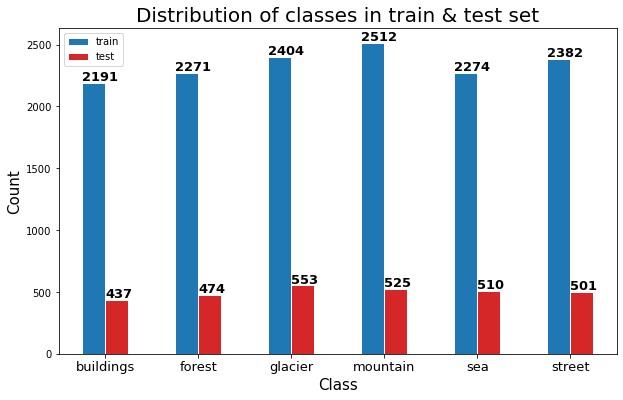

In [6]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

ax = pd.DataFrame({'train': train_counts, 
                   'test': test_counts}, 
                  index=label_dict.keys()
                 ).plot.bar(color=('tab:blue','tab:red'), 
                            edgecolor='white', 
                            figsize=(10,6))
plt.xlabel('Class', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation='horizontal', fontsize=13)
plt.title('Distribution of classes in train & test set', fontsize=20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1)), (x, y + height + 20), fontsize=13, color='black', weight='bold')

plt.show()

In [7]:
print('Shape of training images:', train_set.image_shape)
print('Shape of testing images:', test_set.image_shape)

Shape of training images: (150, 150, 3)
Shape of testing images: (150, 150, 3)


In [8]:
#Class names and indices

print('Class names and their indices in train set:')
train_set.class_indices

Class names and their indices in train set:


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
print('Class names and their indices in test set:')
test_set.class_indices

Class names and their indices in test set:


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [10]:
print("Train batch shape:", train_set[0][0].shape)
print("Test batch shape:", test_set[0][0].shape)

Train batch shape: (32, 150, 150, 3)
Test batch shape: (32, 150, 150, 3)


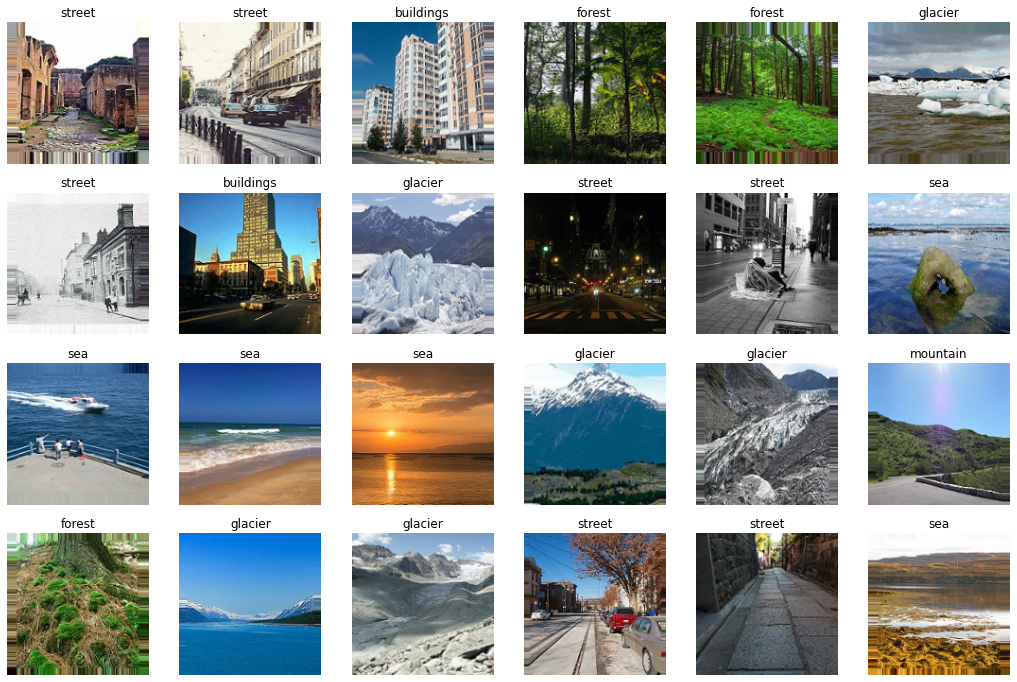

In [11]:
#Let's see some images with the class names on top from the train set

sample_data = train_set[0][0]
sample_label = train_set[0][1]

plt.figure(figsize=(18,12))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(get_class_name(np.argmax(sample_label[i])))

**Here we can see the 6 classes distinctly classified as the images are already labelled in the train set. At the end we will see how our CNN model predicts the classes for unseen and unlabelled images from the prediction set.**

# 3. Convolutional Neural Network

## 3.1 Model Building:

**Now we create a CNN model to predict the class labels. This is the basic CNN model.**

**The steps are:**
- **Build the model.**


- **Compile the model.**


- **Train / fit the data to the model.**

**We build a simple model composed of different layers such as:**

- **Conv2D:** (32 filters of size 3 by 3) The features will be extracted from the image.


- **MaxPooling2D:** The images get half sized, i.e. the images will have fewer pixels.


- **Flatten:** Transforms the format of the images from a 2D-array to a 1D-array of 150 x 150 x 3 pixel values.


- **Dense:** A.K.A. fully connected layers, take the high-level filtered images and translate them into votes. Fully Connected Layer is simply a feed forward neural network.


- **ReLU:** Given a value x, returns max(x, 0), i.e. all the negative values removed.


- **Softmax:** 6 neurons, probability that the image belongs to one of the classes.

In [12]:
#We create a CNN model to predict the class labels.

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
____

## 3.2 Training:

**We fit the CNN model to the data from the training set and use the test set as the validation data. We train it for 20 epochs. The neural network will learn by itself the pattern in order to distinguish each category.**

In [15]:
model.fit(train_set, validation_data = test_set, epochs=20)

Epoch 1/20
439/439 [==============================] - 433s 986ms/step - loss: 1.0015 - acc: 0.6264 - val_loss: 0.7711 - val_acc: 0.7300
Epoch 2/20
439/439 [==============================] - 386s 880ms/step - loss: 0.7176 - acc: 0.7345 - val_loss: 0.6846 - val_acc: 0.7543
Epoch 3/20
439/439 [==============================] - 386s 879ms/step - loss: 0.6063 - acc: 0.7789 - val_loss: 0.5531 - val_acc: 0.8093
Epoch 4/20
439/439 [==============================] - 386s 879ms/step - loss: 0.5478 - acc: 0.8054 - val_loss: 0.5315 - val_acc: 0.8233
Epoch 5/20
439/439 [==============================] - 386s 879ms/step - loss: 0.4984 - acc: 0.8219 - val_loss: 0.5660 - val_acc: 0.8023
Epoch 6/20
439/439 [==============================] - 385s 877ms/step - loss: 0.4588 - acc: 0.8318 - val_loss: 0.4678 - val_acc: 0.8420
Epoch 7/20
439/439 [==============================] - 386s 878ms/step - loss: 0.4271 - acc: 0.8482 - val_loss: 0.5351 - val_acc: 0.8083
Epoch 8/20
439/439 [============================

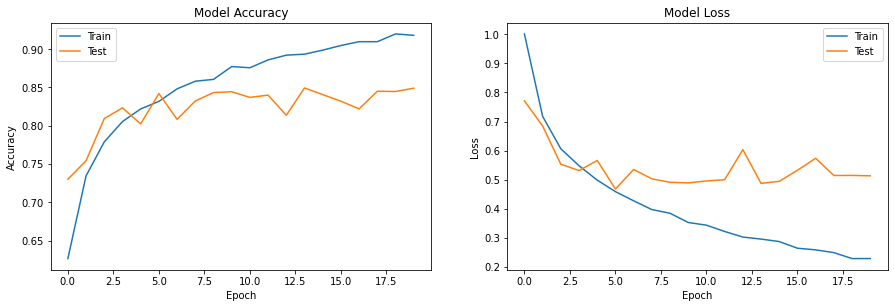

In [18]:
#Plot the accuracy and the loss during the training and testing of NN

plt.figure(figsize=(15,10))

#Model accuracy
plt.subplot(221)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

#Model loss
plt.subplot(222)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

plt.show()

**After training for 20 epochs we find:**

**Model Accuracy:**
- **Train = 92%**

- **Test = 85%**



**Model Loss:**
- **Train = 23%**

- **Test = 51%**

## 3.3 Prediction:

**We use the prediction set for predicting the class of the images.**

- **Number of prediction images: 7301**


- **Shape of prediction images: 150 x 150 x 3**

In [19]:
def get_images(directory):
    #Extract the images from the directory    
    Images = []
    
    for image_file in os.listdir(directory): #Extract the file name of the image from folder
        image = cv2.imread(directory + r'/' + image_file) #Read the image (OpenCV)
        image = cv2.resize(image,(150,150)) #Resize the image
        Images.append(image)
        
    return Images

In [22]:
#Now let's predict the images from the "pred" folder.

pred_images = get_images('seg_pred/seg_pred/') #Extracting the images from the folder
pred_images = np.array(pred_images) #Converting the list of images to numpy array
pred_images.shape

(7301, 150, 150, 3)

In [23]:
model.predict(pred_images)

array([[0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 2.679364e-32, 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]], dtype=float32)

In [25]:
#Predict the class labels from the images

result = model.predict_classes(pred_images)

In [26]:
result

array([2, 3, 5, ..., 2, 1, 5], dtype=int64)

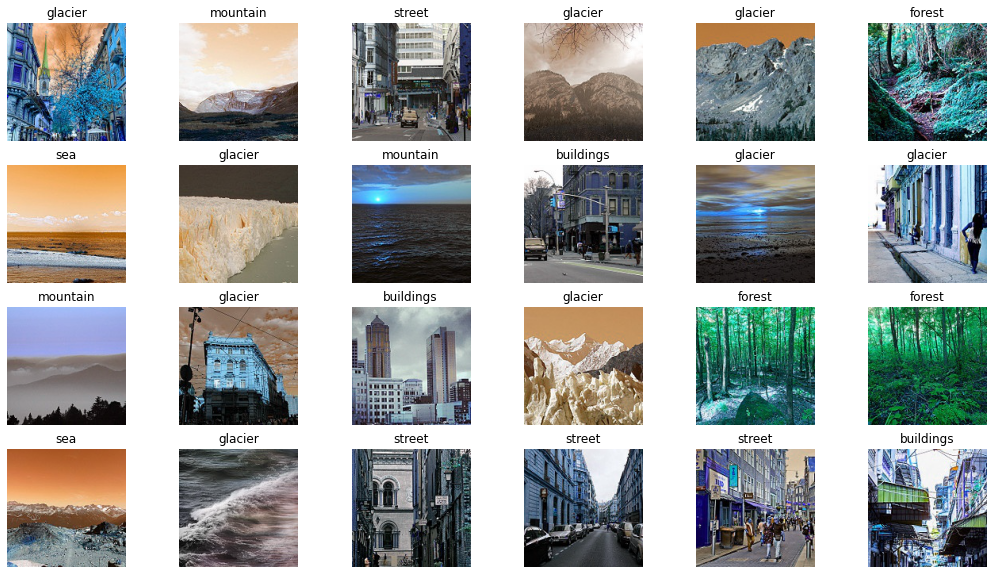

In [27]:
#Now let's see the images with the predicted class names on top

plt.figure(figsize=(18,12))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.axis('off')
    plt.imshow(pred_images[i])
    plt.title(get_class_name(result[i]))

**As we can observe our model predicts most of the images correctly. However, as seen above the model accuracy is 85%. This means that around 15% of the unseen images will get an incorrect prediction.**

## 3.4 Model Improvement:

**Let's try to improve our base model.**

<div class="alert alert-block alert-info">
<b>Note:</b>

- **Due to less computational power of my machine I will not be running the following models here.**


- **However I would like to run the models on the cloud or on a machine with more computational power.**


- **It's just the summary of the models whose accuracy might improve than the base model.**
</div>

## Model 2

In [30]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
    
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)      

## VGG16

**Here we will use the pre-trained VGG16 model. This model was trained on ImageNet dataset for 1000 classes. Features learned by the initial layers of VGG16 model are generic enough to apply for other image classification tasks.**

In [31]:
from tensorflow.keras.applications import VGG16

**Load the VGG16 model's convolutional base.**

**Parameter "include_top=False" lets us drop the 3 fully-connected layers at the top of the network. We also freeze all the convolutional VGG16 layers, so as to avoid destroying any of the information they contain during future training rounds.**

In [32]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

**Let's define the model with it's own classifier on top of VGG16 convolutional base.**

In [33]:
model = Sequential()

model.add(vgg16)

model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               2048250   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1506      
Total params: 16,764,444
Trainable params: 2,049,756
Non-trainable params: 14,714,688
_________________________________________________________________


# 4. Conclusion

**The CNN model we built here is a simple one with only a few layers - 2 convolution layers with relu activation each, 2 pooling layers, a flatten layer and 2 fully connected layers with relu and softmax activation.**

**We got an accuracy of 85% and a loss of 51% on the test set. An accuracy of 85% is not the best, but for a simple model it is good.**

**However, we can improve the accuracy of the model in different ways like mentioned in the [model improvement](#3.4-Model-Improvement:) section. But due to less computational power I choose to build this simple CNN model.**

## 4.1 Recommendations to improve the model performance:

- **Add more layers.**


- **Train the model with more epochs.**


- **Use transfer learning.**


- **Change kernel sizes.**


- **Use early stopping.**

## 4.2 Scope for future work:

- **More types of class can be added.**


- **Collect more data.**


- **Error analysis.**